In [8]:
from __future__ import print_function

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix
from collections import Counter
from  pathlib import Path

# MNIST classification

## 1. Load data

In [9]:
# MNIST labels
classes = np.arange(0, 9 + 1)

# Data transforms 
# 1. Pad 2 - original data is 28x28 pad to have 32x32 to replicate le NET architecture
# 2. To Tensor (this operation scales data between 0 and 1)
# 3. Normalize using mean and std of data scaled between 0 and 1
SCALED_MEAN = 0.1307
SCALED_STD = 0.3081
transform = transforms.Compose([
        transforms.Pad(2),
        transforms.ToTensor(),
        transforms.Normalize((SCALED_MEAN,), (SCALED_STD,))
    ])

# Load datasets
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

print(f"Number of training examples = {len(train_set)}")
train_labels = [p[1] for p in train_set]
label_counts = dict(sorted(dict(Counter(train_labels)).items()))
print(f"Label counts : {label_counts}")
print(f"\nNumber of test examples = {len(test_set)}")

Number of training examples = 60000
Label counts : {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Number of test examples = 10000


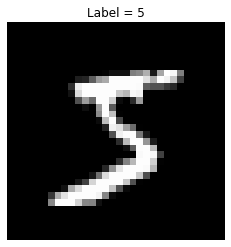

In [10]:
# Define function to visualize an image
def imshow(img, title=""):
    img = img * SCALED_STD + SCALED_MEAN # unnormalize
    npimg = img.numpy()
    plt.title(f"Label = {title}")
    plt.grid(False)
    plt.axis(False)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Visualize example
image, label = train_set[0]
imshow(image, title = label)

## 2. Create model

### 2.1 LeNet architecture ([LeCun et al., 1998])

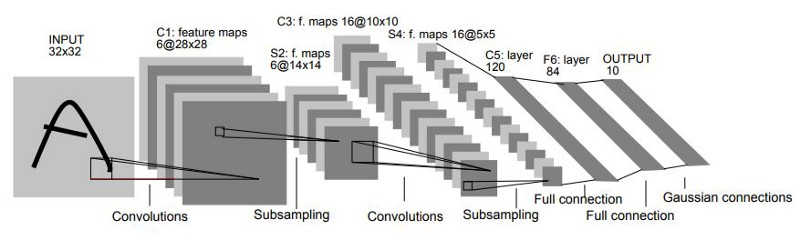

In [11]:
# LeNet (CONV => RELU => POOL) * 2 => FC => RELU => FC => SOFTMAX
# Conv output : [(W−K+2P)/S]+1

class LeNet(nn.Module):
    
    def __init__(self):
        
        super(LeNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        
        # Pooling and ReLu activations
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        # Flatten data
        x = x.view(-1, np.prod(x.size()[1:], axis=0))
        
        # Fully connected layers and ReLu activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Final softmax layer (use log softmax for better performance)
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x

### 2.2 Training process

#### Fit model on training data

- Create a small validation set to visualize performance on unseen data during training

In [12]:
# LeNet 5 architecture
model = LeNet()

# Path to save
path_to_model = Path('./models/lenet5.pth')
path_to_model.parents[0].mkdir(exist_ok = True, parents=True)

# Negative log likelihood loss (for log proba inputs)
loss_function = nn.NLLLoss()

# Stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Number of passes on full data
n_epochs = 10

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    
    # Running loss on whole data
    train_running_loss = 0.0
    test_running_loss = 0.0
    
    # Update step on train data
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Forward pass
        outputs = model(inputs)
        
        # Loss calculation
        loss = loss_function(outputs, labels)
        
        # Back propagations
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Integrate batch loss in running_loss
        train_running_loss += loss.item()
        
    train_loss = train_running_loss / len(train_loader)
    train_losses.append(train_loss)
        
    # Record perf on test data
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):

            inputs, labels = data
            train_labels += list(labels.numpy())

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            test_running_loss += loss.item()
        
    test_loss = test_running_loss / len(test_loader)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch + 1} : train loss {train_loss:.5f} | test loss {test_loss:.5f}")
    running_loss = 0.0
    
torch.save(model.state_dict(), path_to_model)

Epoch 1 : train loss 0.26667 | test loss 0.07882
Epoch 2 : train loss 0.06716 | test loss 0.05839
Epoch 3 : train loss 0.04680 | test loss 0.04716
Epoch 4 : train loss 0.03659 | test loss 0.03332
Epoch 5 : train loss 0.02954 | test loss 0.03272
Epoch 6 : train loss 0.02368 | test loss 0.03092
Epoch 7 : train loss 0.02028 | test loss 0.03225
Epoch 8 : train loss 0.01691 | test loss 0.04739
Epoch 9 : train loss 0.01570 | test loss 0.03412
Epoch 10 : train loss 0.01280 | test loss 0.04419


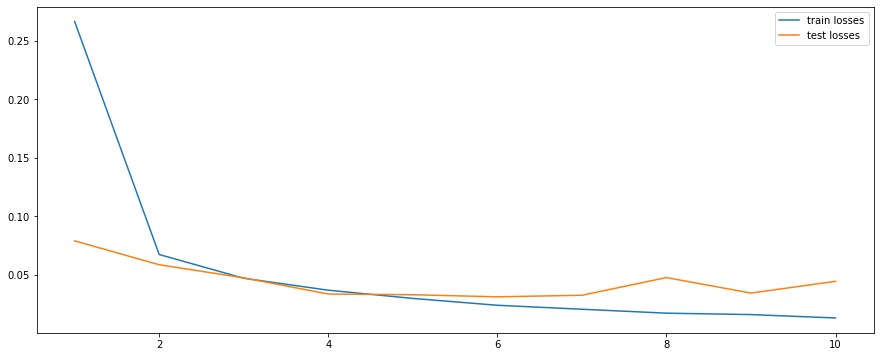

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(1, n_epochs + 1), train_losses, label = "train losses")
plt.plot(np.arange(1, n_epochs + 1), test_losses, label = "test losses")
plt.legend()
plt.show()

#### Get performance of model on test data

In [38]:
# Reload model 
model = LeNet()
model.load_state_dict(torch.load(path_to_model))

# Calculate loss on test data
test_running_loss = 0.0

train_labels = []
train_predictions = []
for i, data in enumerate(testloader, 0):
    
    inputs, labels = data
    train_labels += list(labels.numpy())
    
    outputs = model(inputs)
    train_predictions += list(outputs.max(axis=1).indices.numpy())

Test set loss 0.07762


<AxesSubplot:>

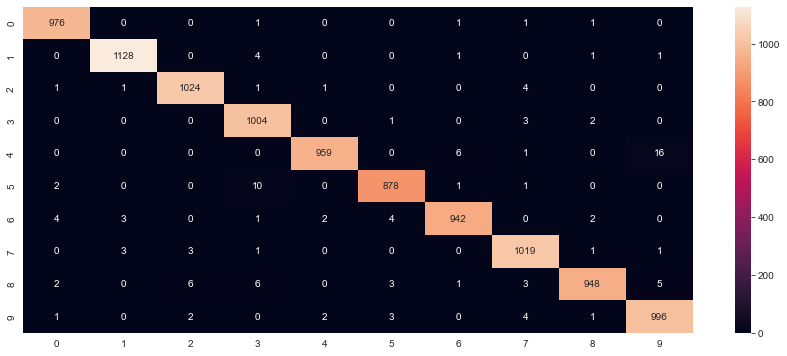

In [46]:
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.heatmap(confusion_matrix(train_labels, train_predictions), annot=True, fmt="d")
plt.show()